In [2]:
from pytorch_tabnet.tab_model import TabNetRegressor

/Users/peggylee/anaconda3/envs/Peggy/lib/python3.12/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [3]:
from tqdm import tqdm
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings("ignore")

In [78]:
# Define the hour and minute ranges for constructing feature column names
hours = range(0, 6, 1)
minutes = range(0, 60, 5)

target_col = 'bg+1-00' # Target column name for prediction
group_col = 'p_num'    # Column name for grouping (e.g., participant number)

# We only need the last 12 time intervals (1 hour)
bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]
cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][:12]

feature_cols = bg_cols + insu_cols + carb_cols + hr_cols + step_cols + cals_cols

In [83]:
path = '/Users/peggylee/Desktop/python/Kaggle_comptete/02_Data'
df_train = pd.read_csv(f"{path}/original_data/train.csv")
df_test = pd.read_csv(f"{path}/original_data/test.csv")
df_subm = pd.read_csv(f"{path}/original_data/sample_submission.csv")
# Some frameworks may not handle column names with special characters like colons properly
df_train.columns = df_train.columns.str.replace(':', '-')
df_test.columns = df_test.columns.str.replace(':', '-')

In [37]:
df_train["carbs-1-00"]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
177019   NaN
177020   NaN
177021   NaN
177022   NaN
177023   NaN
Name: carbs-1-00, Length: 177024, dtype: float64

## Data Pre Processing

In [102]:
class DataTransform:
    """
    1. drop activity columns that missing rate were high
    2. transform time format(hour, minute) by using sin/cos 
    3. impute data by back/forward as this was a time-series data
    4. only keep last 12 time intervals, others would compute their mean and standard deviation
    
    """
    def  __init__(self, train, test):
        self.train = train
        self.test = test
        
    def dropcolumn(self,df):
        drop_activity = df.columns[df.columns.str.startswith('activity-')]
        df_drop = df.drop(columns = drop_activity)
        
        return df_drop
    
    def create_time(self, df):
        df['hr'] = pd.to_datetime(df['time'],format = '%H:%M:%S').dt.hour
        df['min'] = pd.to_datetime(df['time'],format = '%H:%M:%S').dt.minute
        #df['sc'] = pd.to_datetime(df['time'],format = '%H:%M:%S').dt.second
        df['hour_sin'] = np.sin(2 * np.pi * df['hr'] / 12)
        df['hour_cos'] = np.cos(2 * np.pi * df['hr'] / 12)
        df['min_sin'] = np.sin(2 * np.pi * df['min'] / 60)
        df['min_cos'] = np.cos(2 * np.pi * df['min'] / 60)
        df = df.drop(columns = ['hr','min'])

        return df
    def impute(self,df):
        bg_impute = df[df.columns[df.columns.str.startswith('bg-')]]
        bg_impute = bg_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        insu_impute = df[df.columns[df.columns.str.startswith('insulin-')]]
        insu_impute = insu_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        insu_impute = insu_impute.fillna(method = 'bfill',axis = 0).fillna(method = 'ffill',axis = 0)
        cals_impute = df[df.columns[df.columns.str.startswith('cals-')]]
        cals_impute = cals_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        cals_impute = cals_impute.fillna(method = 'bfill',axis = 0).fillna(method = 'ffill',axis = 0)
        hr_impute = df[df.columns[df.columns.str.startswith('hr-')]]
        hr_impute = hr_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        hr_impute = hr_impute.fillna(method = 'bfill',axis = 0).fillna(method = 'ffill',axis = 0)
        steps_impute = df[df.columns[df.columns.str.startswith('steps-')]]
        steps_impute = steps_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        steps_impute = steps_impute.fillna(method = 'bfill',axis = 0).fillna(method = 'ffill',axis = 0)
        carbs_impute = df[df.columns[df.columns.str.startswith('carbs-')]]
        carbs_impute = carbs_impute.T.fillna(method = 'ffill',axis = 0).fillna(method='bfill', axis=0).T
        carbs_impute = carbs_impute.fillna(method = 'bfill',axis = 0).fillna(method = 'ffill',axis = 0)
        
        impute_final = pd.concat([bg_impute,insu_impute,cals_impute,hr_impute,steps_impute,carbs_impute],axis = 1)
        return impute_final
    
    def mean_sd(self, df):
        for k in [2,3,4,5,6]:
            bg_cols   = [f'bg-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            insu_cols = [f'insulin-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            carb_cols = [f'carbs-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            hr_cols   = [f'hr-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            step_cols = [f'steps-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            cals_cols = [f'cals-{i}-{j:02d}' for i, j in product(hours, minutes)][12*(k-1):12*k]
            df[f'bg-last{k}-hour-mean'] = df[bg_cols].mean(axis=1)
            df[f'bg-last{k}-hour-sd'] = df[bg_cols].std(axis=1)
            df[f'insu-last{k}-hour-mean'] = df[insu_cols].mean(axis=1)
            df[f'insu-last{k}-hour-sd'] = df[insu_cols].std(axis=1)
            df[f'carbs-last{k}-hour-mean'] = df[carb_cols].mean(axis=1)
            df[f'carbs-last{k}-hour-sd'] = df[carb_cols].std(axis=1)
            df[f'hr-last{k}-hour-mean'] = df[hr_cols].mean(axis=1)
            df[f'hr-last{k}-hour-sd'] = df[hr_cols].std(axis=1)
            df[f'step-last{k}-hour-mean'] = df[step_cols].mean(axis=1)
            df[f'step-last{k}-hour-sd'] = df[step_cols].std(axis=1)
            df[f'cals-last{k}-hour-mean'] = df[cals_cols].mean(axis=1)
            df[f'cals-last{k}-hour-sd'] = df[cals_cols].std(axis=1)
            df = df.drop(columns = bg_cols)
            df = df.drop(columns = insu_cols)
            df = df.drop(columns = carb_cols)
            df = df.drop(columns = hr_cols)
            df = df.drop(columns = step_cols)
            df = df.drop(columns = cals_cols)
        return df
            
            
        
    def final(self,df,type_data):
        drop_df = self.dropcolumn(df)
        time_new_df = self.create_time(drop_df)
        impute_df = self.impute(time_new_df)
        time_df = time_new_df[['hour_sin','hour_cos','min_sin','min_cos']]
        time_df1 = pd.concat([impute_df,time_df],axis = 1)
        final_pre = self.mean_sd(time_df1)
        final_pre = pd.concat([final_pre,df[['p_num']]],axis = 1)
        if type_data == 'train':
            outcome_df = df[['bg+1-00']]
            final = pd.concat([final_pre,outcome_df],axis = 1)
            return final 
        else:
            return final_pre

In [104]:
transformer = DataTransform(df_train, df_test)
train_impute = transformer.final(df_train,"train")
test_impute = transformer.final(df_test,"test")

In [108]:
train_impute.isna().sum().sum()

0

## TabNet setting 

In [109]:
grouped_features = []

# Iterate through each set of related columns (e.g., blood glucose, insulin, etc.)
for colset in [bg_cols, insu_cols, carb_cols, hr_cols, step_cols, cals_cols]:
    group_idxs = [idx for idx, col in enumerate(feature_cols) if col in colset]
    grouped_features.append(group_idxs)

In [110]:
drop_col = ['p_num','bg+1-00']
X = train_impute.drop(columns = drop_col)
y = train_impute[['bg+1-00']]
groups = train_impute['p_num']
cv = GroupKFold(5)
df_subm['bg+1:00'] = 0.0
test_impute = test_impute.drop(columns = 'p_num')

In [111]:
for idx_train, idx_valid in cv.split(X, y, groups=groups):
    
    # Split the data into training and validation sets for the current fold
    X_train, y_train = X.iloc[idx_train].to_numpy(), y.iloc[idx_train].to_numpy()
    X_valid, y_valid = X.iloc[idx_valid].to_numpy(), y.iloc[idx_valid].to_numpy()
    
    # Initialize the TabNet Regressor model
    reg = TabNetRegressor(
        grouped_features=grouped_features, 
    )
    
    # Train the model using the training set and validate using the validation set
    reg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        batch_size=1024,
    )
    
    # Prepare the test data and make predictions
    X_test = test_impute.to_numpy()
    
    # Aggregate the predictions across the 5 folds (averaging for ensemble)
    df_subm['bg+1:00'] += reg.predict(X_test)[:, 0] / 5
    


epoch 0  | loss: 10.54235| val_0_rmse: 2.89285 |  0:00:23s
epoch 1  | loss: 4.15723 | val_0_rmse: 2.23656 |  0:00:40s
epoch 2  | loss: 4.07299 | val_0_rmse: 2.28291 |  0:00:55s
epoch 3  | loss: 4.02138 | val_0_rmse: 2.25793 |  0:01:09s
epoch 4  | loss: 3.95712 | val_0_rmse: 2.21673 |  0:01:23s
epoch 5  | loss: 3.8998  | val_0_rmse: 2.2149  |  0:01:37s
epoch 6  | loss: 3.90399 | val_0_rmse: 2.25888 |  0:01:51s
epoch 7  | loss: 3.92931 | val_0_rmse: 2.21985 |  0:02:05s
epoch 8  | loss: 3.82449 | val_0_rmse: 2.23294 |  0:02:18s
epoch 9  | loss: 3.80393 | val_0_rmse: 2.20372 |  0:02:33s
epoch 10 | loss: 3.76966 | val_0_rmse: 2.32585 |  0:02:46s
epoch 11 | loss: 3.87486 | val_0_rmse: 2.22671 |  0:02:58s
epoch 12 | loss: 3.82017 | val_0_rmse: 2.24371 |  0:03:11s
epoch 13 | loss: 3.79935 | val_0_rmse: 2.22964 |  0:03:23s
epoch 14 | loss: 3.82727 | val_0_rmse: 2.30553 |  0:03:40s
epoch 15 | loss: 3.77667 | val_0_rmse: 2.28055 |  0:03:56s
epoch 16 | loss: 3.77028 | val_0_rmse: 2.21557 |  0:04:1

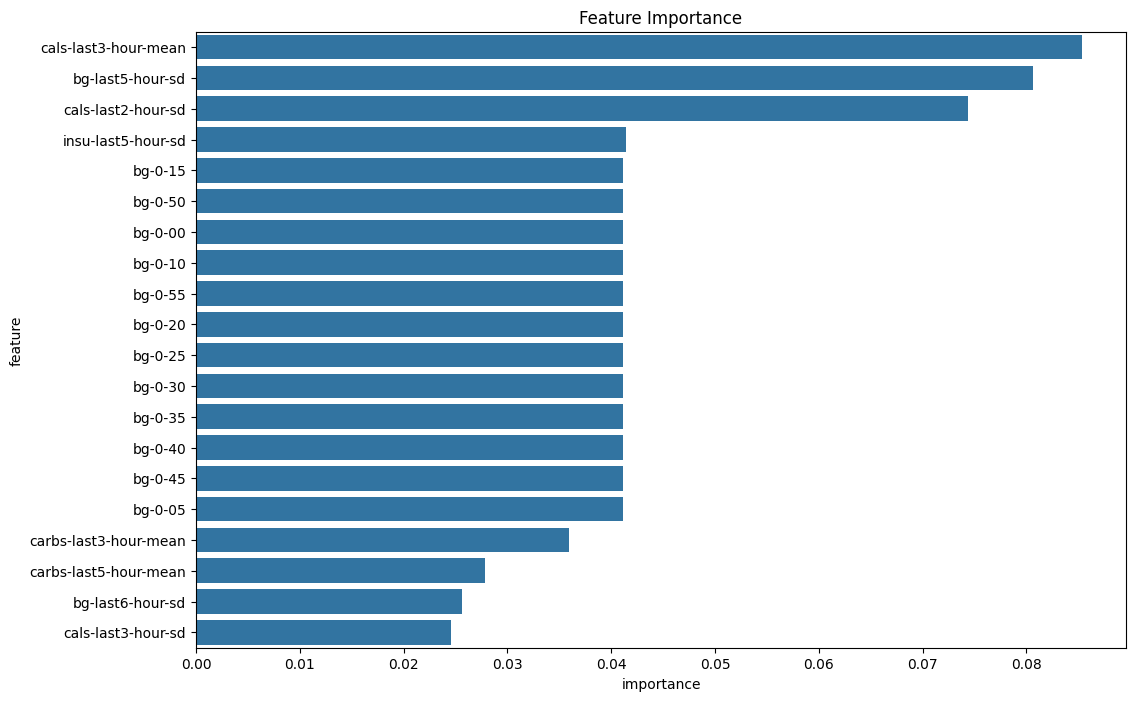

In [124]:
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': reg.feature_importances_
})

feature_importances.sort_values(
    by="importance", ascending=False, inplace=True,
)

plt.figure(figsize = (12, 8))
sns.barplot(
    y=feature_importances["feature"][:20], 
    x=feature_importances["importance"][:20],
)
plt.title("Feature Importance")
plt.show()

In [118]:
df_subm.to_csv(f"{path}/Temp/submission.csv",index=False)

In [123]:
X.columns

Index(['bg-0-55', 'bg-0-50', 'bg-0-45', 'bg-0-40', 'bg-0-35', 'bg-0-30',
       'bg-0-25', 'bg-0-20', 'bg-0-15', 'bg-0-10',
       ...
       'insu-last6-hour-mean', 'insu-last6-hour-sd', 'carbs-last6-hour-mean',
       'carbs-last6-hour-sd', 'hr-last6-hour-mean', 'hr-last6-hour-sd',
       'step-last6-hour-mean', 'step-last6-hour-sd', 'cals-last6-hour-mean',
       'cals-last6-hour-sd'],
      dtype='object', length=136)